# Librairies

In [1]:
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression

/home/wawa/anaconda3/envs/vectorization/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the data

In [2]:

# Load IMDb dataset
raw = load_dataset("imdb")

# Combine train + test into a single dataset (50k rows)
all_data = concatenate_datasets([raw["train"], raw["test"]])
texts = all_data['text']
print(len(all_data))  # 50000
print(all_data[0]['text'])

50000
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwee

## stritified k-folds

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
y      = np.array(all_data['label'])
_, idx_1k = next(sss.split(texts, y))
texts_1k = np.array(texts)[idx_1k]
y_1k     = y[idx_1k]

In [ ]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(y_1k)), y_1k))

## Transformers model

In [8]:
import torch.nn as nn
import torch
import torch.optim as optim


device ='cpu'
from transformers import AutoTokenizer, AutoModel
model_name = "sentence-transformers/all-MiniLM-L6-v2"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder   = AutoModel.from_pretrained(model_name).to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

class TransformersEmbedder(nn.Module):
    def __init__(self, tokenizer, encoder, device,batch_size: int = 64):
        super().__init__()
        self.tokenizer =  tokenizer
        self.encoder  = encoder
        self.device = device
        self.batch_size = batch_size


    def forward(self, texts):
        
        embs = []
        
        with torch.no_grad():
            for i in range(0, len(texts), self.batch_size):
                batch = texts[i:i+self.batch_size]
                encoded = self.tokenizer(
                    batch,
                    padding=True,
                    truncation=True,
                    return_tensors="pt"
                ).to(self.device)
            
                output = self.encoder(**encoded)
                embeddings = mean_pooling(output, encoded['attention_mask']) # CLS token
                embeddings = F.normalize(embeddings, p=2, dim=1)
                embs.append(embeddings)
        return np.vstack(embs)  # shape: (B, hidden_size)
    

model = TransformersEmbedder(tokenizer, encoder, device,64)

In [10]:
texts_1k

array(['This is an atrocious movie. Two demented young women seduce and torture a middle aged man. There\'s not much to give away in regards to a plot or a "spoiler". I would only comment that the ending is nearly the most preposterous part of the flick. Much of the film involves Locke and Camp cackling obnoxiously, all the while grinning psychotically at the camera. Add to this a soundtrack that repeats again and again, including a vaudevillian song about "dear old dad" that suggests an incestuous quality the viewer never really sees. The music is annoying at first, then ends up subjecting the viewer to a torture worse than that depicted on the screen. The theme here is of youth run amok, understandable as a reaction to the \'60s, but done with little imagination or style. Avoid it!',
       'well,there isnt much to say about this movie. its simply trash. very poor acting, poor script, and lame story.... well, the actress,(i odnt even know her name) who played mainrole,(not the blond 

In [11]:
All_mini_vectors = model(list(texts_1k))

3

# Static vector

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


class TfidfEmbedder:
    def __init__(self,
                 analyzer="word",
                 ngram_range=(1,2),
                 min_df=2,
                 max_df=0.9,
                 sublinear_tf=True,
                 norm="l2"):
        self.vec = TfidfVectorizer(analyzer=analyzer,
                                   ngram_range=ngram_range,
                                   min_df=min_df, max_df=max_df,
                                   sublinear_tf=sublinear_tf,
                                   norm=norm)
    def fit(self, texts):
        self.vec.fit(texts)
        return self
    def transform(self, texts):
        return self.vec.transform(texts)
    


tfidfVectorizer = TfidfVectorizer()
tfidfVectorizer.fit(all_data['text'][:1000])


,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [13]:
tfidfVectorizer.transform(["I love wawa","wawa"])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (2, 16118)>

In [16]:
All_mini_vectors.shape

(10000, 384)

# Training and score computation

In [19]:
from sklearn.metrics import accuracy_score, f1_score


accuracies_A = []
accuracies_B = []
for fold, (tr,te) in enumerate(skf.split(np.zeros(len(y_1k)), y_1k)):
    tr_transformers = All_mini_vectors[tr]
    te_transformers = All_mini_vectors[te]
    
   
    y_test = y_1k[te]

    tr = list(tr)
    te = list(te)

    tf_embed = TfidfEmbedder()
    tf_vector_train = tf_embed.vec.fit_transform(texts_1k[tr])
    tf_vector_test = tf_embed.transform(texts_1k[te])
    


    model_A = LogisticRegression(max_iter=200).fit(tr_transformers,y_1k[tr])
    model_B =  LogisticRegression(max_iter=200).fit(tf_vector_train,y_1k[tr])

    y_hat_A =  model_A.predict(te_transformers)
    y_hat_B = model_B.predict(tf_vector_test)

    accuracies_A.append(accuracy_score(y_test,y_hat_A))
    accuracies_B.append(accuracy_score(y_test,y_hat_B))







In [ ]:
accuracies_A = np.array(accuracies_A)
accuracies_B = np.array(accuracies_B)

In [75]:
import random
from statistics import mean

def paired_perm_folds(acc_A, acc_B, n_perm=10000, seed=42):
    rng = np.random.default_rng(seed)
    d = np.asarray(acc_A, float) - np.asarray(acc_B, float)  # paired diffs per fold
    delta_obs = d.mean()
    k = d.size
    diffs = np.empty(n_perm, float)
    for i in range(n_perm):
        sign = np.where(rng.random(k) < 0.5, 1.0, -1.0)      # flip each pair with p=0.5
        diffs[i] = (sign * d).mean()
    p = (np.sum(np.abs(diffs) >= abs(delta_obs)) + 1) / (n_perm)  # two-sided
    return float(delta_obs), float(p), diffs


obs, p, diffs = paired_perm_folds(accuracies_A,accuracies_B)

print(f"p_value : {p}")



p_value : 0.0002


In [73]:
from scipy.stats import permutation_test

def statistic(x, y):
    return np.mean(y) - np.mean(x)

permutation_test((accuracies_A,accuracies_B),statistic,permutation_type='samples')

PermutationTestResult(statistic=np.float64(0.0657034845940393), pvalue=np.float64(0.0002), null_distribution=array([ 0.02350687,  0.02089646,  0.00809805, ..., -0.00291926,
        0.02330606,  0.01128445], shape=(9999,)))

# Vizualisation

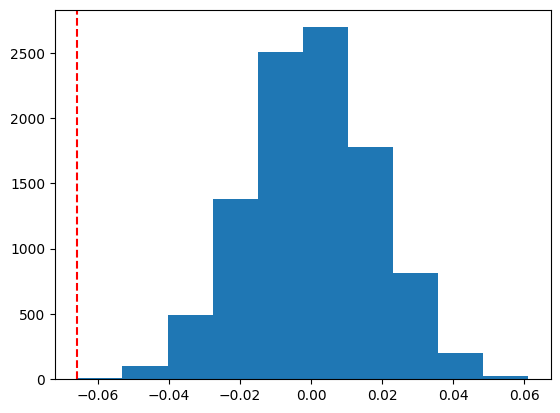

In [79]:
import matplotlib.pyplot as plt



plt.hist(diffs)
plt.axvline(x=obs, color='r', linestyle='--', label='observed difference')